In [1]:
import numpy as np

from help_functies import *
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
x_list = []
y_list = []
for i in range(1, 901):
    x_list.append(np.cos(0.1 * i * np.pi / 180))
    y_list.append(np.sin(0.1 * i * np.pi / 180))

In [230]:
ts = np.linspace(0, 2500, 2501)
l = len(ts)
data_np = np.hstack([np.reshape(ts, (l,1)), np.zeros((l, 6))])
data = pd.DataFrame(data_np, columns=['timestamp', 'x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro'])
data['z_gyro'][901:1801] = np.array([-100]*900)
data['x_acc'][:901] = np.ones(901)
data['x_acc'][901:1801] = x_list
data['y_acc'][901:1801] = y_list
data['y_acc'][1801:] = np.ones(l-1801)



data.head(2000)

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1995,1995.0,0.0,1.0,0.0,0.0,0.0,0.0
1996,1996.0,0.0,1.0,0.0,0.0,0.0,0.0
1997,1997.0,0.0,1.0,0.0,0.0,0.0,0.0
1998,1998.0,0.0,1.0,0.0,0.0,0.0,0.0


In [164]:
ts = np.linspace(0, 10000, 10001)
l = len(ts)
data_np = np.hstack([np.reshape(ts, (l,1)), np.zeros((l, 6))])
data = pd.DataFrame(data_np, columns=['timestamp', 'x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro'])
data['x_acc'] = np.ones(l)
data.head(200)

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
195,195.0,1.0,0.0,0.0,0.0,0.0,0.0
196,196.0,1.0,0.0,0.0,0.0,0.0,0.0
197,197.0,1.0,0.0,0.0,0.0,0.0,0.0
198,198.0,1.0,0.0,0.0,0.0,0.0,0.0


In [231]:
y11 = np.array([data['x_acc'][0], data['y_acc'][0], data['z_acc'][0]])
gb = y11 / np.linalg.norm(y11)
gn = np.array([0, 0, 1])
mn = np.array([1, 0, 0])
ymb= np.array([1, 2, 3])
mb = np.cross(gb, np.cross(ymb / np.linalg.norm(ymb), gb))

A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) - np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Eigenvalues are sorted in ascending order by np.linalg.eigh, 
# and the corresponding eigenvectors are columns of 'eigenvectors'
max_eigenvalue_index = np.argmax(eigenvalues)
max_eigenvector = eigenvectors[:, max_eigenvalue_index]
q11 = max_eigenvector

In [232]:
print(rotate_vector(np.array([data['x_acc'][0], data['y_acc'][0], data['z_acc'][0]]), q11))

[ 1.11022302e-16 -2.22044605e-16  1.00000000e+00]


In [233]:
q = q11
q_list = [q]

for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    omega = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)
    q = quat_mul(q, expq_omega)
    q_list.append(q)

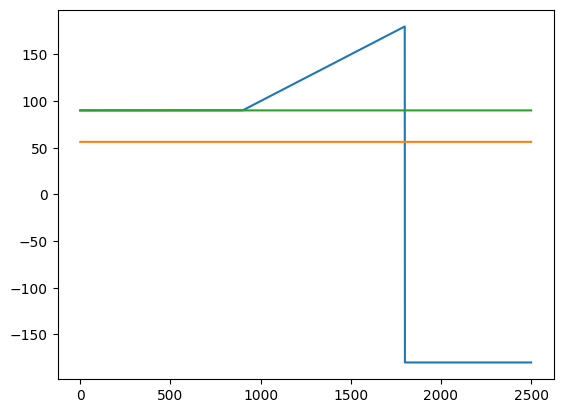

In [234]:
euler_x = []
euler_y = []
euler_z = []

q_norm = []
for q in q_list:
    if np.linalg.norm(q) >= 1:
        q_norm.append(q / 1.00001)
    else:
        q_norm.append(q)

for q in q_norm:
    euler = quaternion_to_euler(q) * 180 / np.pi
    euler_x.append(euler[0])
    euler_y.append(euler[1])
    euler_z.append(euler[2])

plt.plot(euler_x)
plt.plot(euler_y)
plt.plot(euler_z)

In [235]:
print(q_list[50], quat_to_euler(q_list[50]) * 180 / np.pi)

[ 0.20490834 -0.67676626 -0.20490834 -0.67676626] [ 90.         -56.30993247  90.        ]


In [236]:
dqde = 1*np.array([
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1]
])

sigma_etha = np.array([
    [(np.pi / 9) ** 2, 0, 0],
    [0, (np.pi / 9) ** 2, 0],
    [0, 0, (np.pi / 9) ** 2]
])

P11 = 0.25 * np.matmul(np.matmul(np.matmul(np.matmul(right_quat_mul(q11), dqde), sigma_etha), dqde.T), right_quat_mul(q11))

In [237]:
qtmin1tmin1 = np.reshape(q11, 4)
Ptmin1tmin1 = P11

q_list_km = [qtmin1tmin1]

std_gyro = [0.09748312, 0.06679045, 0.07106568]
std_acc = [0.002165  , 0.00211811, 0.00305338]

Q = np.array([
    [std_gyro[0] ** 2, 0, 0],
    [0, std_gyro[1] ** 2, 0],
    [0, 0, std_gyro[2] ** 2]
])

R = np.array([
    [std_acc[0] ** 2, 0, 0],
    [0, std_acc[1] ** 2, 0],
    [0, 0, std_acc[2] ** 2],
])

epsilon_list = []

for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    gyro_measurement = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    omega = gyro_measurement
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)

    Ftmin1 = right_quat_mul(expq_omega)
    Gtmin1 = - 0.5 * dt * np.matmul(left_quat_mul(qtmin1tmin1), dqde)

    Pttmin1 = np.matmul(np.matmul(Ftmin1, Ptmin1tmin1), Ftmin1.T) + np.matmul(np.matmul(Gtmin1, Q), Gtmin1.T)

    qttmin1 = quat_mul(qtmin1tmin1, expq_omega)

    # q0, q1, q2, q3 = quaternion_conjugate(qttmin1)
    q0, q1, q2, q3 = qttmin1    # Zou kunnen dat hier de geconjugeerde genomen moet worden!!
    H = 2 * np.array([
        [-q2, q3, -q0, q1],
        [q1, q0, q3, q2],
        [2 * q0, 0, 0, 2 * q3]
    ])
    # H = -2 * np.array([
    #     [q2, q3, q0, q1],
    #     [-q1, -q0, q3, q2],
    #     [2 * q0, 0, 0, 2 * q3]
    # ])
    S = np.matmul(np.matmul(H, Pttmin1), H.T) + R
    K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))

    yat = np.array([data['x_acc'][i], data['y_acc'][i], data['z_acc'][i]])
    # yattmin1 = rotate_vector(gn, qttmin1) #quaternion_conjugate(qttmin1)) # Zou kunnen dat hier een min voor moet!!! en geconjugeerde
    yattmin1 = rotate_vector(gn, quaternion_conjugate(qttmin1))
    epsilon = yat - yattmin1
    print(data['timestamp'][i], yat, yattmin1, qttmin1)
    q_tt_measure = np.reshape(qttmin1, (4, 1)) + np.matmul(K, np.reshape(epsilon, (3, 1)))
    # P_tt_measure = Pttmin1 - np.matmul(np.matmul(K, S), K.T)
    P_tt_measure = Pttmin1 - np.matmul(np.matmul(K, H), Pttmin1)
    qtt = q_tt_measure / ((np.linalg.norm(q_tt_measure)))
    #J = np.matmul(q_tt_measure, q_tt_measure.T) / (np.linalg.norm(q_tt_measure) ** 3)
    Ptt = P_tt_measure  #np.matmul(np.matmul(J, P_tt_measure), J.T)

    Ptmin1tmin1 = Ptt
    qtmin1tmin1 = np.reshape(qtt, 4)

    q_list_km.append(qtmin1tmin1)
    epsilon_list.append(epsilon)
    

1.0 [1. 0. 0.] [ 1.00000000e+00 -2.22044605e-16  1.11022302e-16] [ 0.20490834 -0.67676626 -0.20490834 -0.67676626]
2.0 [1. 0. 0.] [1.00000000e+00 1.11022302e-16 0.00000000e+00] [ 0.20490834 -0.67676626 -0.20490834 -0.67676626]
3.0 [1. 0. 0.] [1.00000000e+00 5.55111512e-17 0.00000000e+00] [ 0.20490834 -0.67676626 -0.20490834 -0.67676626]
4.0 [1. 0. 0.] [1.00000000e+00 5.55111512e-17 0.00000000e+00] [ 0.20490834 -0.67676626 -0.20490834 -0.67676626]
5.0 [1. 0. 0.] [1.00000000e+00 5.55111512e-17 0.00000000e+00] [ 0.20490834 -0.67676626 -0.20490834 -0.67676626]
6.0 [1. 0. 0.] [1.00000000e+00 5.55111512e-17 0.00000000e+00] [ 0.20490834 -0.67676626 -0.20490834 -0.67676626]
7.0 [1. 0. 0.] [1.00000000e+00 5.55111512e-17 0.00000000e+00] [ 0.20490834 -0.67676626 -0.20490834 -0.67676626]
8.0 [1. 0. 0.] [1.00000000e+00 5.55111512e-17 0.00000000e+00] [ 0.20490834 -0.67676626 -0.20490834 -0.67676626]
9.0 [1. 0. 0.] [1.00000000e+00 5.55111512e-17 0.00000000e+00] [ 0.20490834 -0.67676626 -0.20490834 -0

In [238]:
print(rotate_vector(np.array([data['x_acc'][0], data['y_acc'][0], data['z_acc'][0]]), q11))

[ 1.11022302e-16 -2.22044605e-16  1.00000000e+00]


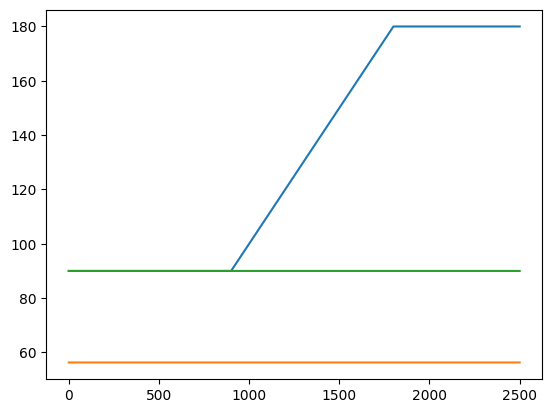

In [239]:
euler_x = []
euler_y = []
euler_z = []

q_norm = []
for q in q_list_km:
    if np.linalg.norm(q) >= 1:
        q_norm.append(q / 1.00001)
    else:
        q_norm.append(q)

for q in q_norm:
    euler = quaternion_to_euler(q) * 180 / np.pi
    euler_x.append(euler[0])
    euler_y.append(euler[1])
    euler_z.append(euler[2])

plt.plot(euler_x)
plt.plot(euler_y)
plt.plot(euler_z)

In [228]:
print(q_list[-1], q_list_km[-1])    

[ 0.62343809 -0.62343809  0.33365394 -0.33365394] [ 0.0401429   0.0401429  -0.70596639 -0.70596639]


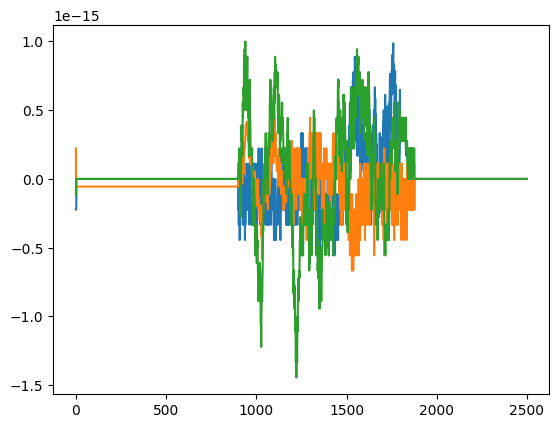

In [240]:
epsilons = np.concatenate(epsilon_list)
epsilons = np.reshape(epsilons, (int(len(epsilons) / 3), 3))

plt.plot(epsilons[:, 0])
plt.plot(epsilons[:, 1])
plt.plot(epsilons[:, 2])

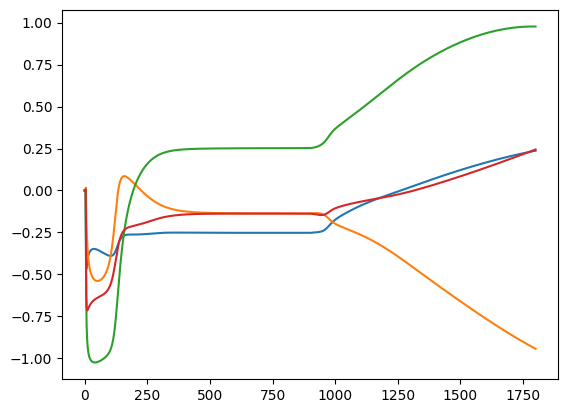

In [30]:
qs = np.reshape(np.concatenate(q_list), (int(len(q_list)), 4))
qkms = np.reshape(np.concatenate(q_list_km), (int(len(q_list_km)), 4))
dif = qs - qkms
plt.plot(dif[:,0])
plt.plot(dif[:,1])
plt.plot(dif[:,2])
plt.plot(dif[:,3])
plt.show()

In [31]:
print(q_list[1500], q_list_km[1500])

[ 0.51583896 -0.68855094  0.16092731 -0.48364261] [ 0.39414514 -0.02790274 -0.72205628 -0.56789592]
